In [24]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import butter, lfilter, spectrogram
from sklearn.metrics import mean_squared_error


In [25]:
fs = 16000
duration = 2
t = np.linspace(0, duration, int(fs * duration), endpoint=False)
clean_signal = np.sin(2 * np.pi * 300 * t) + 0.6 * np.sin(2 * np.pi * 1000 * t)

In [26]:

white_noise = 0.3 * np.random.randn(len(t))
hum_50hz = 0.3 * np.sin(2 * np.pi * 50 * t)
noise = white_noise + hum_50hz

noisy_signal = clean_signal + noise
sf.write("C:/Users/tripl/Desktop/sound.wav", noisy_signal, fs)


In [27]:
def butter_filter(cutoff, fs, order=5, filter_type='low'):
    nyq = 0.5 * fs
    norm_cutoff = np.array(cutoff) / nyq if isinstance(cutoff, (list, tuple)) else cutoff / nyq
    b, a = butter(order, norm_cutoff, btype=filter_type, analog=False)
    return b, a

def apply_filter(data, cutoff, fs, order=5, filter_type='low'):
    b, a = butter_filter(cutoff, fs, order, filter_type)
    return lfilter(b, a, data)


In [28]:

low_filtered = apply_filter(noisy_signal, cutoff=800, fs=fs, order=6, filter_type='low')
band_stopped = apply_filter(noisy_signal, cutoff=[48, 52], fs=fs, order=4, filter_type='bandstop')

sf.write("lowpass_filtered.wav", low_filtered, fs)
sf.write("bandstop_filtered.wav", band_stopped, fs)


In [29]:
def calculate_snr(clean, noisy):
    power_signal = np.mean(clean ** 2)
    power_noise = np.mean((clean - noisy) ** 2)
    return 10 * np.log10(power_signal / power_noise)


snr_before = calculate_snr(clean_signal, noisy_signal)
snr_after = calculate_snr(clean_signal, low_filtered)
mse = mean_squared_error(clean_signal, low_filtered)

print(f"SNR Before Filtering: {snr_before:.2f} dB")
print(f"SNR After Filtering: {snr_after:.2f} dB")
print(f"MSE: {mse:.6f}")


SNR Before Filtering: 7.05 dB
SNR After Filtering: -1.90 dB
MSE: 1.052002


In [35]:

def plot_all(signal, title, color='blue'):
    plt.figure(figsize=(12, 6))

    # Time domain
    plt.subplot(3,1,1)
    plt.plot(t[:800], signal[:800], color=color)
    plt.title(f"{title} - Time Domain")
    plt.grid()

    # FFT
    plt.subplot(3,1,2)
    N = len(signal)
    fft_vals = np.abs(np.fft.fft(signal))[:N//2]
    fft_freqs = np.fft.fftfreq(N, 1/fs)[:N//2]
    plt.plot(fft_freqs, fft_vals, color=color)
    plt.title(f"{title} - Frequency Domain")
    plt.xlim(0, 2000)
    plt.grid()

    # Spectrogram
    plt.subplot(3,1,3)
    f, t_spec, Sxx = spectrogram(signal, fs)
    
    # Log scale to avoid log(0) errors
    Sxx = np.log10(Sxx + 1e-10) 
    
    plt.pcolormesh(t_spec, f, Sxx, shading='gouraud')
    plt.title(f"{title} - Spectrogram")
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='dB')

    plt.tight_layout()
    plt.show()


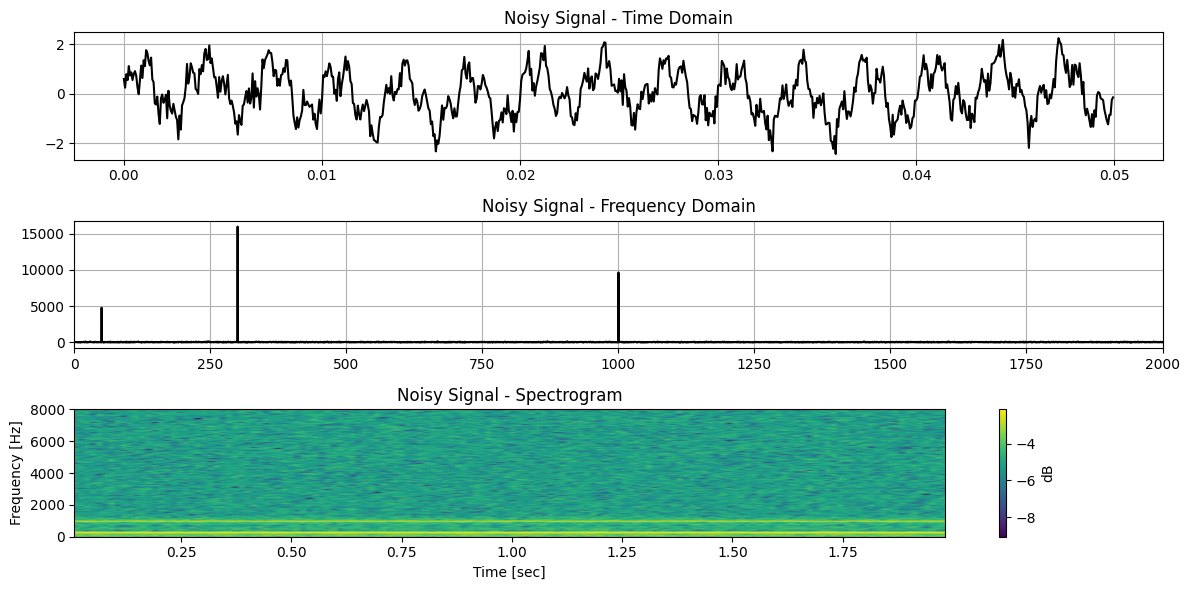

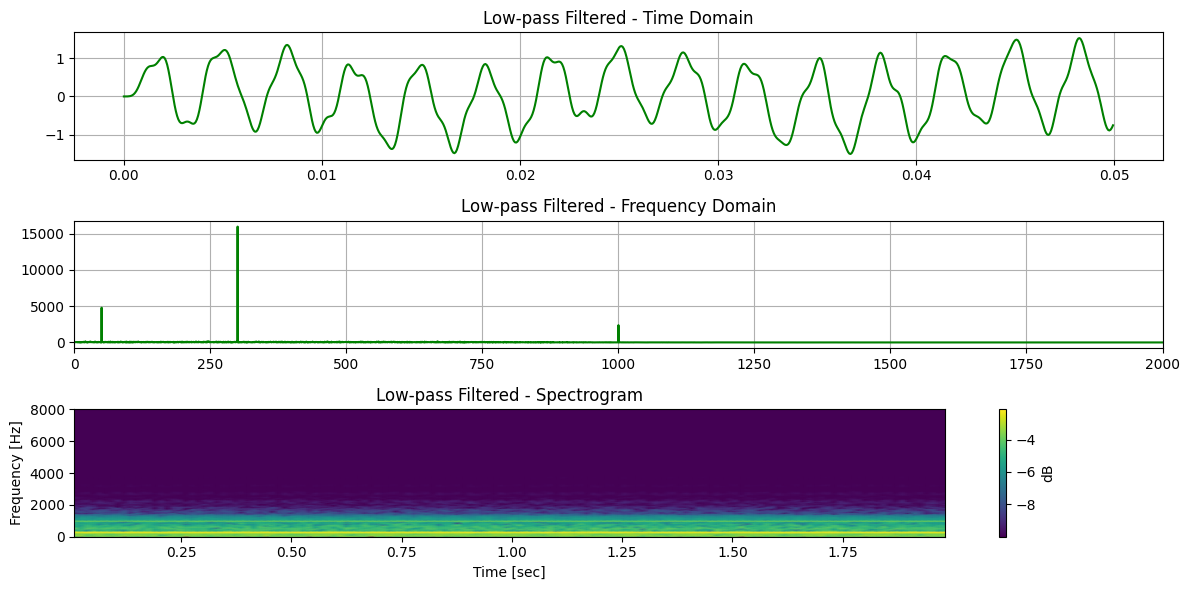

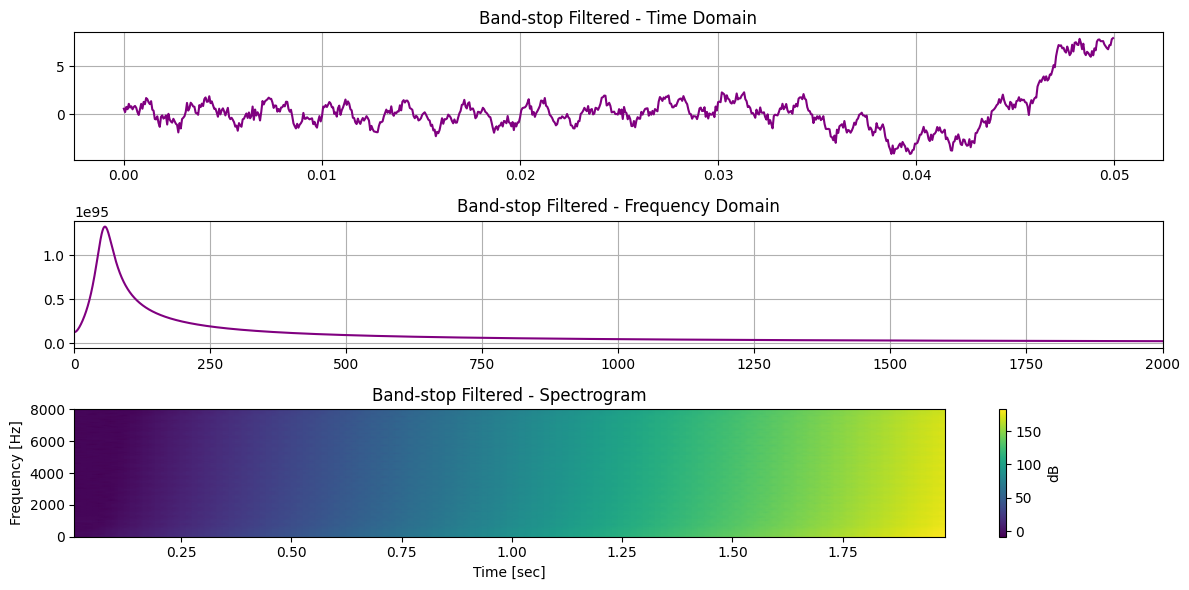

In [36]:
plot_all(noisy_signal, "Noisy Signal", 'black')
plot_all(low_filtered, "Low-pass Filtered", 'green')
plot_all(band_stopped, "Band-stop Filtered", 'purple')
